# Geo Visualization of Merchant Data
- Visualize how many merchants made the transactions in each state

In [3]:
import sys  
import pandas as pd
import sqlite3
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyspark.sql.functions import countDistinct, sum, col, avg, count
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pathlib import Path
from pyspark.sql import DataFrame
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
from scripts.constants import *
from scripts.plotting import *
from scripts.read import *
from scripts.join import *

In [4]:
spark = create_spark()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 14:33:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/13 14:33:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Read the required dataframes

In [5]:
shape_file = read_curated_sa2_shape_file('.')
transaction = read_curated_transactions_all(spark, '.')

#### Select the columns we need (merchant related columns) to plot in transactions dataframe

#### Process the shape file for plotting

In [6]:
# drop the last 3 rows in shape file
shape_file = shape_file[:-3]

# drop the null values in geometry column
shape_file = shape_file.dropna(subset=['geometry'])

# transfrom the geometry column to langitude and latitude
shape_file = shape_file.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Define a dictionary to map full state names to abbreviations
state_abbreviations = {
    'New South Wales': 'NSW',
    'Victoria': 'VIC',
    'Queensland': 'QLD',
    'South Australia': 'SA',
    'Western Australia': 'WA',
    'Tasmania': 'TAS',
    'Northern Territory': 'NT',
    'Australian Capital Territory': 'ACT',
    'Other Territories': 'Other'
}

# Replace full state names with abbreviations
shape_file[STATE] = shape_file[STATE].replace(state_abbreviations)

shape_file

,sa2_code,sa2_name,state,geometry
0,101021007,Braidwood,NSW,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,NSW,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,NSW,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,NSW,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,NSW,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...
2463,801111141,Namadgi,ACT,"POLYGON ((148.80407 -35.37619, 148.80417 -35.3..."
2466,901011001,Christmas Island,Other,"POLYGON ((105.67393 -10.41566, 105.67399 -10.4..."
2467,901021002,Cocos (Keeling) Islands,Other,"MULTIPOLYGON (((96.91512 -12.14044, 96.91513 -..."
2468,901031003,Jervis Bay,Other,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."


#### Plot the map to visualize how many merchants made the transactions in each state
- From the map, we can see that there are 4,327 distinct merchants who have their customers in Victoria, slightly higher than New South Wales (4,324) and Queensland (4,291). 

- The Australian Capital Territory has the fewest merchants (3,199), followed by the Northern Territory (3,304).

In [7]:
# Calculate the count of different merchant_abn by state
state_merchant_counts = transaction.groupBy(STATE).agg(countDistinct(MERCHANT_ABN).alias("merchant_abn_count"))

# Convert state_merchant_counts to a Pandas DataFrame
state_merchant_counts_pd = state_merchant_counts.toPandas()

# Merge the counts with sa2_shapefile using state as the key
state_merged_data = shape_file.merge(state_merchant_counts_pd, on=STATE, how=LEFT_JOIN)

/Users/DalilaKhairudin/Desktop/MAST30034/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:518: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, state, sa2_code, label in zip(data.geometry.centroid.x, data.geometry.centroid.y, data["state"], data["sa2_code"], data["merchant_abn_count"]):


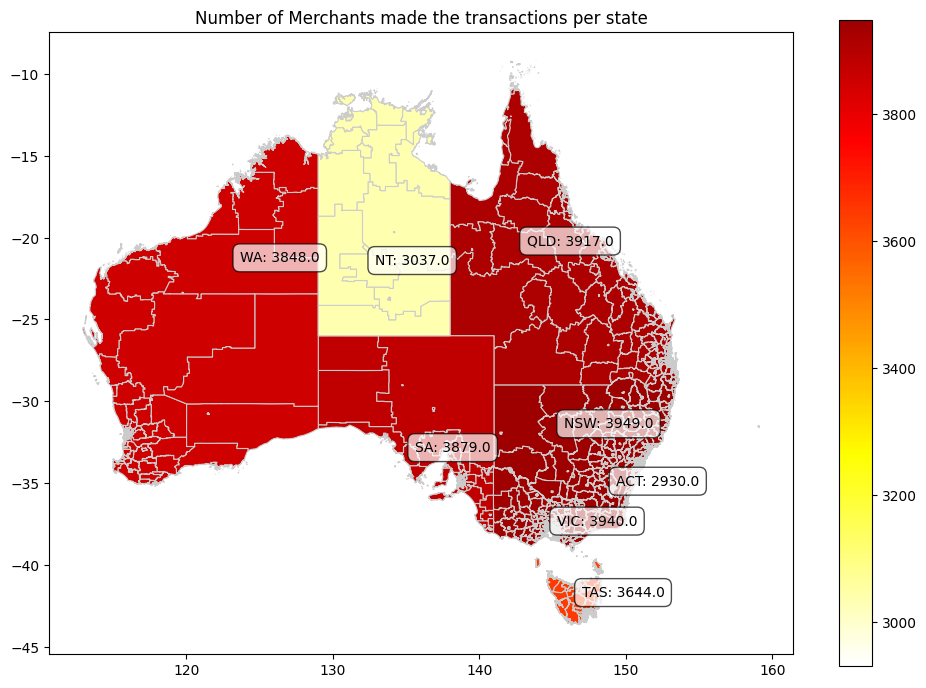

In [8]:
plot_and_save_merchants_per_state(state_merged_data, "Number of Merchants made the transactions per state", '.' + NUMBER_OF_MERCHANT_MADE_TRANSACTION_WITH_BY_STATE_PLOT_PATH)

#### Plot the map to visualize how many merchants made their transactions in each sa2 area
- From the map, we can observe that in most SA2 regions of Victoria and SA2 regions near Perth in Western Australia, there are numerous different merchants completing transactions with local customers. This suggests that these areas serve as primary sources of customers for a majority of businesses. 

- Similarly, the northeastern region of South Australia and the southwestern region of Queensland also emerge as significant customer sources for many businesses.
 
- In the Loddon region, a total of 3,161 distinct merchants have their customers, indicating its importance as a commercial hub.

In [9]:
# Calculate the count of different merchant_abn by state
sa2_merchant_counts = transaction.groupBy(SA2_CODE).agg(countDistinct(MERCHANT_ABN).alias("sa2_merchant_abn_count"))

# Convert state_merchant_counts to a Pandas DataFrame
sa2_merchant_counts_pd = sa2_merchant_counts.toPandas()

# Merge the counts with sa2_shapefile using state as the key
sa2_merged_data = shape_file.merge(sa2_merchant_counts_pd, on=SA2_CODE, how=LEFT_JOIN)

# transfer the NaN value in sa2_merchant_abn_count to 0
sa2_merged_data["sa2_merchant_abn_count"] = sa2_merged_data["sa2_merchant_abn_count"].fillna(0)

/Users/DalilaKhairudin/Desktop/MAST30034/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:580: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, sa2_name, label, state_name in zip(top_5_sa2.geometry.centroid.x, top_5_sa2.geometry.centroid.y, top_5_sa2["sa2_name"], top_5_sa2["sa2_merchant_abn_count"], top_5_sa2["state"]):


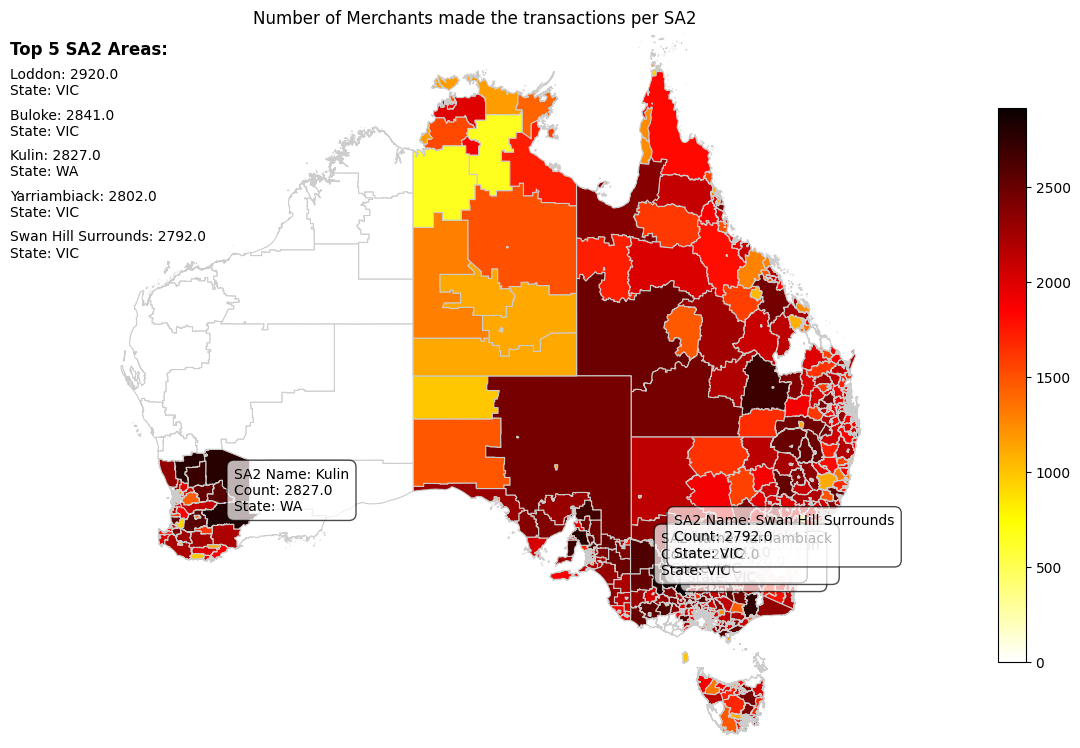

In [10]:
plot_and_save_merchants_per_sa2(sa2_merged_data, "Number of Merchants made the transactions per SA2", '.' + NUMBER_OF_MERCHANT_MADE_TRANSACTION_WITH_BY_SA2_PLOT_PATH)

#### Plot the map to visualize the sum of the business transaction per state
- NSW has the highest total dollar value (945.35 M), followed by Victoria (868.07 M) and Queensland (866.41).

- Australian Capital Territory has the lowest total dollar value (66 M), followed by Northern Territory (68.23 M).

In [11]:
# sum the dollar_value by state
state_dollar_value = transaction.groupBy(STATE).agg(sum(col(DOLLAR_VALUE)).alias("total_dollar_value"))

# convert total_dollar_value to million and only keep 3 decimal places
state_dollar_value_in_million = state_dollar_value.withColumn("total_dollar_value", F.round(col("total_dollar_value")/1000000, 3))

# convert state_dollar_value to a Pandas DataFrame
state_dollar_value_in_million_pd = state_dollar_value_in_million.toPandas()

# Merge the counts with sa2_shapefile using state as the key
dollar_per_state_merged_data = shape_file.merge(state_dollar_value_in_million_pd, on=STATE, how=LEFT_JOIN)

dollar_per_state_merged_data

,sa2_code,sa2_name,state,geometry,total_dollar_value
0,101021007,Braidwood,NSW,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",776.644
1,101021008,Karabar,NSW,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3...",776.644
2,101021009,Queanbeyan,NSW,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",776.644
3,101021010,Queanbeyan - East,NSW,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",776.644
4,101021012,Queanbeyan West - Jerrabomberra,NSW,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3...",776.644
...,...,...,...,...,...
2449,801111141,Namadgi,ACT,"POLYGON ((148.80407 -35.37619, 148.80417 -35.3...",53.541
2450,901011001,Christmas Island,Other,"POLYGON ((105.67393 -10.41566, 105.67399 -10.4...",NaN
2451,901021002,Cocos (Keeling) Islands,Other,"MULTIPOLYGON (((96.91512 -12.14044, 96.91513 -...",NaN
2452,901031003,Jervis Bay,Other,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556...",NaN


/Users/DalilaKhairudin/Desktop/MAST30034/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:625: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, state, sa2_code, label in zip(data.geometry.centroid.x, data.geometry.centroid.y, data["state"], data["sa2_code"], data["total_dollar_value"]):


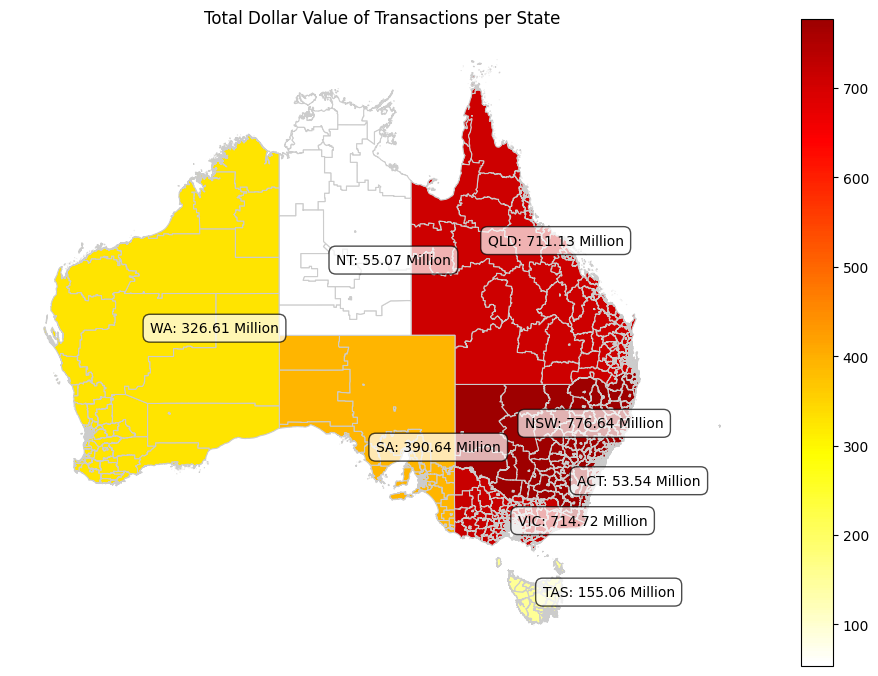

In [12]:
plot_and_save_dollar_per_state(dollar_per_state_merged_data, "Total Dollar Value of Transactions per State", '.' + SPENT_DOLLAR_BY_STATE_PLOT_PATH)

#### Plot the map to visualize the sum of the business transaction per sa2 area

- It appears that VIC and the regions near Perth in WA have many SA2 areas with very high total transaction amounts.

- The northeastern sa2 regions of SA and the southwestern sa2 regions of QLD also have relatively high total transaction amounts. 

- Although NSW has the highest total transaction amount in Australia, there aren't many individual SA2 regions with extremely high total transaction amounts. Each sa2 region in NSW have the similar total dollar values. 

- Apart from SA2 regions near Perth, the total transaction amounts in the rest of WA are close to zero. 

- Most areas in NT have very low total transaction amounts.

In [13]:
# sum the dollar_value by state
sa2_dollar_value = transaction.groupBy(SA2_CODE).agg(sum(col(DOLLAR_VALUE)).alias("total_dollar_value"))

# convert total_dollar_value to million and only keep 3 decimal places
sa2_dollar_value_in_million = sa2_dollar_value.withColumn("total_dollar_value", F.round(col("total_dollar_value")/1000000, 3))

# convert state_dollar_value to a Pandas DataFrame
sa2_dollar_value_in_million_pd = sa2_dollar_value_in_million.toPandas()

# Merge the counts with sa2_shapefile using state as the key
dollar_per_sa2_merged_data = shape_file.merge(sa2_dollar_value_in_million_pd, on=SA2_CODE, how=LEFT_JOIN)

# fill the NaN value in total_dollar_value with 0
dollar_per_sa2_merged_data["total_dollar_value"] = dollar_per_sa2_merged_data["total_dollar_value"].fillna(0)

/Users/DalilaKhairudin/Desktop/MAST30034/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:687: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, sa2_name, label, state_name in zip(top_5_sa2.geometry.centroid.x, top_5_sa2.geometry.centroid.y, top_5_sa2["sa2_name"], top_5_sa2["total_dollar_value"], top_5_sa2["state"]):


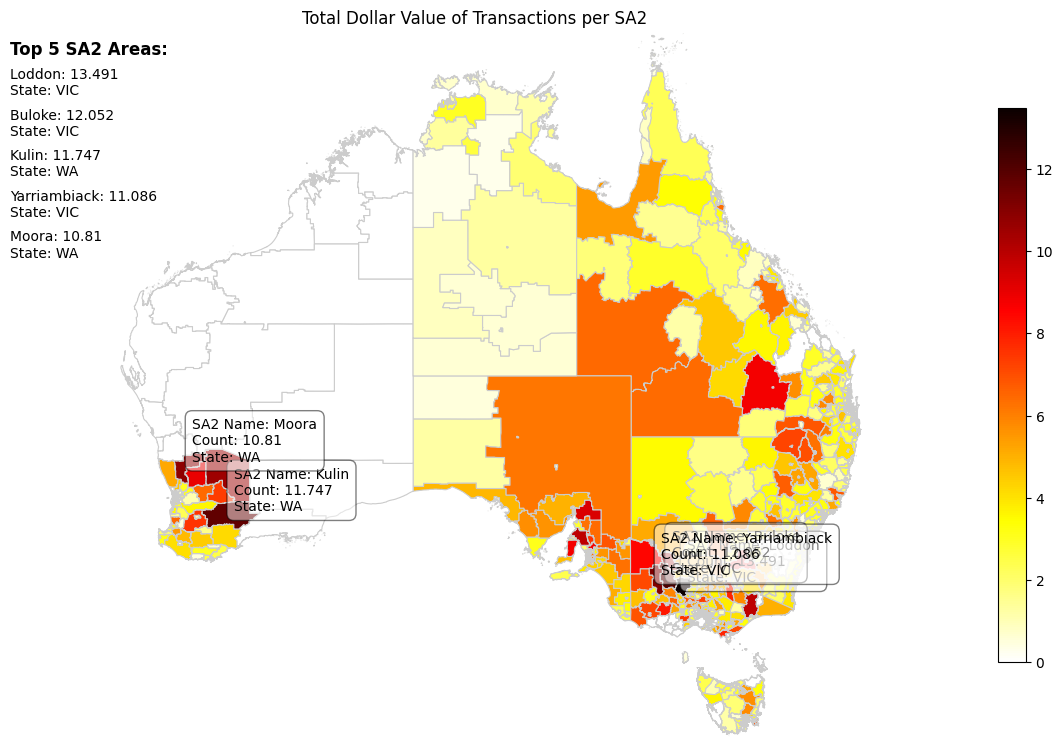

In [14]:
plot_and_save_dollar_per_sa2(dollar_per_sa2_merged_data, "Total Dollar Value of Transactions per SA2", '.' + SPENT_DOLLAR_BY_SA2_PLOT_PATH)

#### Visualize the average customer royalty of the merchants in each state
- NT has the highest customer royalty (7.295), followed by ACT (5.484) and QLD (5.032)

- SA has the lowest customer royalty (2.687), followed by VIC (2.917)

In [15]:
# only choose state, merchant_abn, consumer_id, order_id, sa2_code, sa2_name columns in transaction
transaction_for_customer_royalty = transaction.select(STATE, MERCHANT_ABN, CONSUMER_ID, ORDER_ID, SA2_CODE, SA2_NAME)

window_spec = Window.partitionBy(STATE, MERCHANT_ABN, CONSUMER_ID)

# calculate the customer loyalty of a customer for a merchant 
transaction_with_loyalty = transaction_for_customer_royalty.withColumn('loyalty_count', count(col(ORDER_ID)).over(window_spec))

# calculate the average customer royaly for each merchants
loyalty_data = transaction_with_loyalty.groupBy(STATE, MERCHANT_ABN).agg(avg('loyalty_count').alias('avg_loyalty'))

# calculate the average customer loyalty for each state and keep 3 decimal places
state_avg_loyalty = loyalty_data.groupBy(STATE).agg(avg('avg_loyalty').alias('avg_loyalty')).withColumn("avg_loyalty", F.round(col("avg_loyalty"), 3))

# convert result to a Pandas DataFrame
state_avg_loyalty_pd = state_avg_loyalty.toPandas()

# Merge the counts with sa2_shapefile using state as the key
loyalty_per_state_merged_data = shape_file.merge(state_avg_loyalty_pd, on=STATE, how=LEFT_JOIN)

loyalty_per_state_merged_data

23/10/13 14:35:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `consumer_id` cannot be resolved. Did you mean one of the following? [`order_id`, `user_id`, `gender`, `name`, `gender_Male`].;
'Project [state#8, merchant_abn#0L, 'consumer_id, order_id#3, sa2_code#11, sa2_name#59]
+- Relation [merchant_abn#0L,user_id#1L,dollar_value#2,order_id#3,order_year#4,order_day_of_month#5,order_day_of_week#6,order_month#7,state#8,postcode#9,gender#10,sa2_code#11,ratio#12,earners2015-2016#13,earners2016-2017#14,earners2017-2018#15,earners2018-2019#16,earners2019-2020#17,median_age2015-2016#18,median_age2016-2017#19,median_age2017-2018#20,median_age2018-2019#21,median_age2019-2020#22,earningsum2015-2016#23,... 145 more fields] parquet


/Users/jinghao/Documents/GitHub/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:698: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, state, sa2_code, label in zip(data.geometry.centroid.x, data.geometry.centroid.y, data["state"], data["sa2_code"], data["avg_loyalty"]):


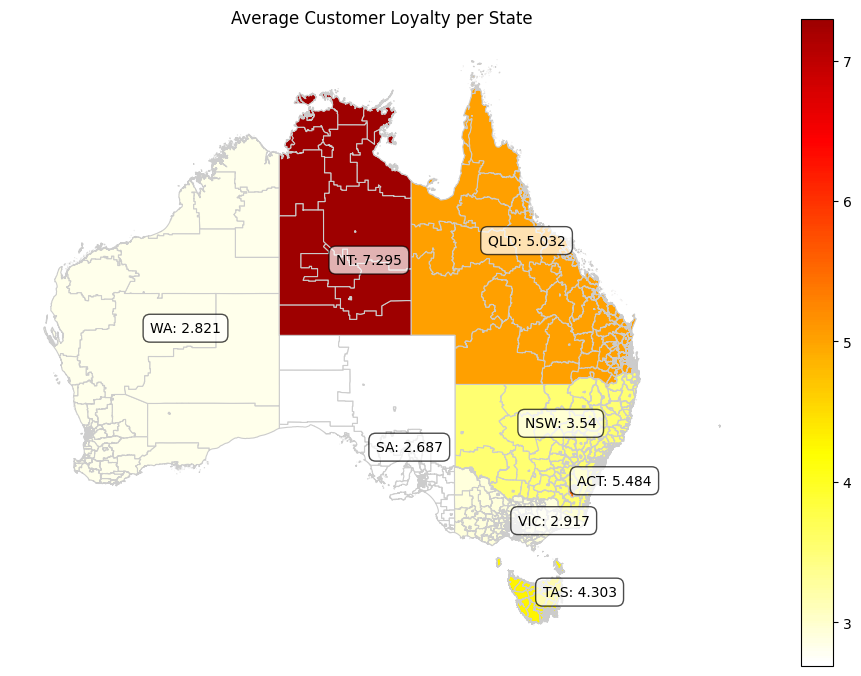

In [ ]:
plot_and_save_customer_loyalty_per_state(loyalty_per_state_merged_data, "Average Customer Loyalty per State", '.' + CUSTOMER_LOYALTY_BY_STATE_PLOT_PATH)

#### Visuaize the customer royalty of each merchant in every sa2 area
- East Arm, Thamarrurr and Tiwi Island in NT has the same higest average customer royalty (20.202).

- Genrally, most of the sa2 areas in NT have a relatively higher average customer royalty. 

- Excluding the areas near Perth, the average customer royalty in most of the sa2 regions in WA is close to zero.

In [ ]:
# calculate the customer loyalty of a customer for a merchant
transaction_with_loyalty = transaction.withColumn('loyalty_count', count(col(ORDER_ID)).over(window_spec))

# calculate the average customer royaly for each merchants
loyalty_data = transaction_with_loyalty.groupBy(SA2_CODE, MERCHANT_ABN).agg(avg('loyalty_count').alias('avg_loyalty'))

# calculate the average customer loyalty for each sa2 area and keep 3 decimal places
sa2_avg_loyalty = loyalty_data.groupBy(SA2_CODE).agg(avg('avg_loyalty').alias('avg_loyalty')).withColumn("avg_loyalty", F.round(col("avg_loyalty"), 3))

# convert result to a Pandas DataFrame
sa2_avg_loyalty_pd = sa2_avg_loyalty.toPandas()

# Merge the counts with sa2_shapefile using sa2 code as the key
loyalty_per_sa2_merged_data = shape_file.merge(sa2_avg_loyalty_pd, on=SA2_CODE, how=LEFT_JOIN)

# fill the NaN value in avg_loyalty with 0
loyalty_per_sa2_merged_data["avg_loyalty"] = loyalty_per_sa2_merged_data["avg_loyalty"].fillna(0)

loyalty_per_sa2_merged_data

,sa2_code,sa2_name,state,geometry,avg_loyalty
0,101021007,Braidwood,NSW,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4...",3.966
1,101021008,Karabar,NSW,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3...",0.000
2,101021009,Queanbeyan,NSW,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3...",0.000
3,101021010,Queanbeyan - East,NSW,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3...",0.000
4,101021012,Queanbeyan West - Jerrabomberra,NSW,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3...",1.351
...,...,...,...,...,...
2449,801111141,Namadgi,ACT,"POLYGON ((148.80407 -35.37619, 148.80417 -35.3...",0.000
2450,901011001,Christmas Island,Other,"POLYGON ((105.67393 -10.41566, 105.67399 -10.4...",0.000
2451,901021002,Cocos (Keeling) Islands,Other,"MULTIPOLYGON (((96.91512 -12.14044, 96.91513 -...",0.000
2452,901031003,Jervis Bay,Other,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556...",0.000


/Users/jinghao/Documents/GitHub/bnpl-industry-project-open-source-industry-project-7/scripts/plotting.py:758: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, sa2_name, label, state_name in zip(top_5_sa2.geometry.centroid.x, top_5_sa2.geometry.centroid.y, top_5_sa2["sa2_name"], top_5_sa2["avg_loyalty"], top_5_sa2["state"]):


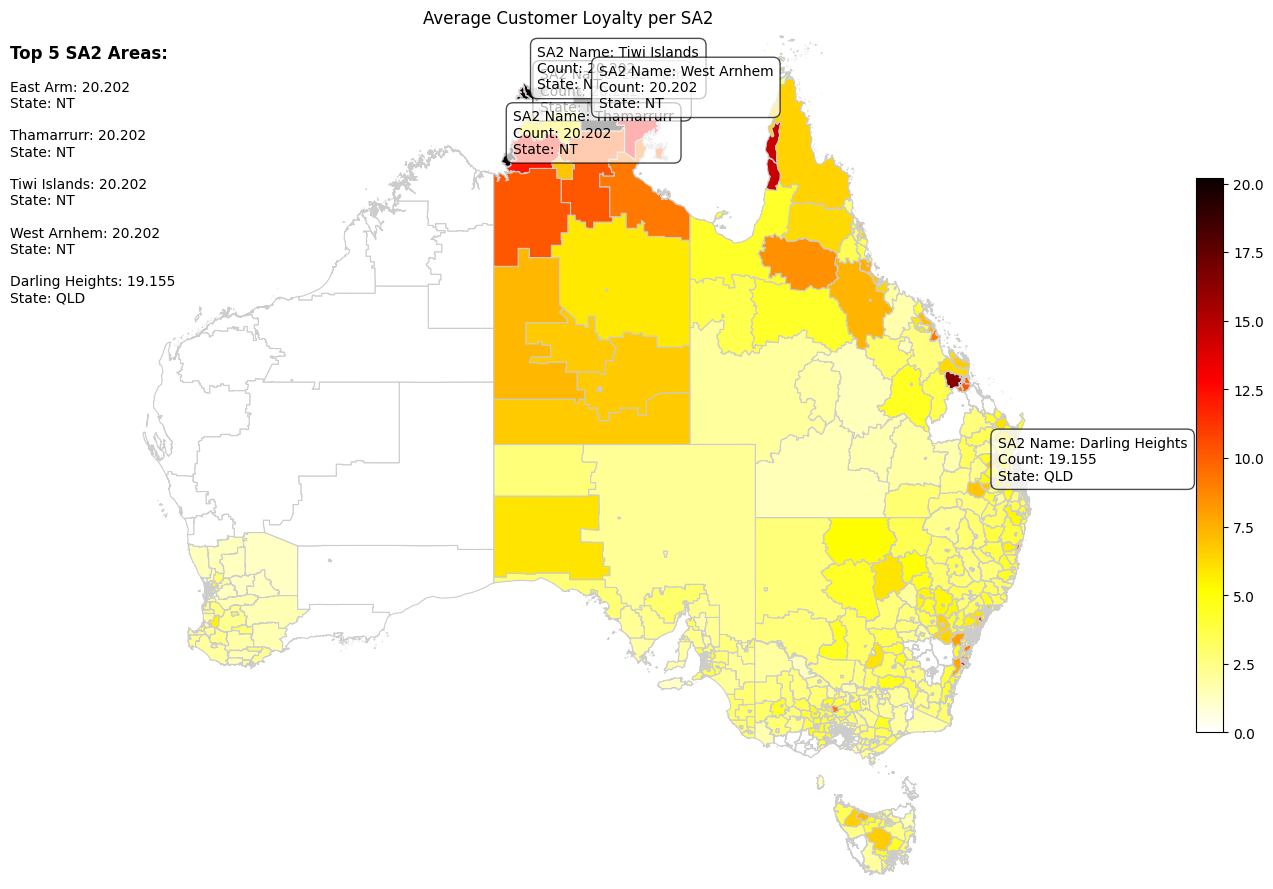

In [ ]:
plot_and_save_customer_royalty_per_sa2(loyalty_per_sa2_merged_data, "Average Customer Loyalty per SA2", '.' + CUSTOMER_LOYALTY_BY_SA2_PLOT_PATH)